<a href="https://colab.research.google.com/github/DmitryKostin/data-analysis-projects/blob/main/03_rfm_analysis_project/rfm_analysis_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RFM-анализ и сегментация клиентов e-commerce маркетплейса

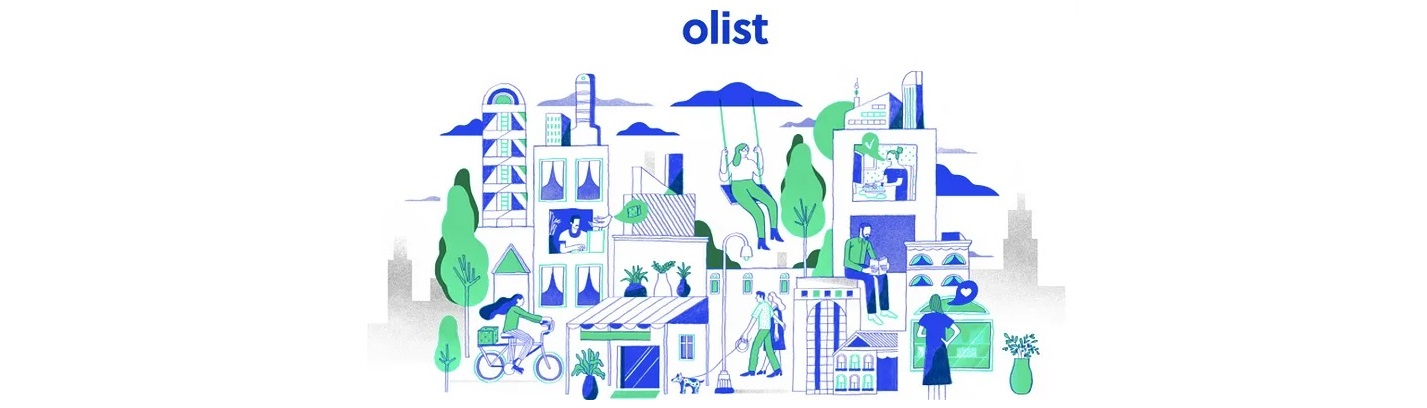

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка и изучение данных](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
* [Шаг 3. Исследовательский анализ данных](#step_3)
    * [Анализ профилей клиентов](#step_3_1)
    * [Геоанализ клиентов](#step_3_2)
    * [Анализ параметров доставки](#step_3_3)
* [Шаг 4. RFM-анализ](#step_4)
* [Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

Olist — это бразильский маркетплейс, работающий в сегменте электронной коммерции, с 2015 года работает еще и как технологическая компания SaaS (программное обеспечение как услуга). Он предлагает торговую площадку для электронной коммерции розничным торговцам всех размеров для увеличения их продаж.

Концепция Olist состоит из трех аспектов: программное обеспечение, контракты с основными торговыми площадками и обмен репутацией. Бизнес-модель Olist связывает рынки, потребителей и розничных продавцов.

**Цель проекта** — провести сегментацию клиентов маркетплейса Olist с помощью методов RFM-анализа.


**Исходные данные** — публичный [набор данных](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) компании Olist, содержащий информацию о 100 тысячах заказов с сентября 2016 года по август 2018 года.

RFM-анализ — метод анализа, позволяющий сегментировать клиентов по частоте и сумме покупок и выявлять тех, которые приносят больше денег.

RFM-анализ помогает разделить клиентов на категории разных размеров, чтобы было легче понять, кто из них лучше всего реагирует на текущие рекламные кампании и на будущие активности.

Как правило, небольшой процент пользователей реагирует на общие рекламные предложения. RFM-анализ и RFM-сегментация являются отличным методом прогнозирования реакции клиента и улучшения взаимодействия, а также способствует повышению прибыли. RFM-анализ исследует поведение покупателей, чтобы определить, как работать с каждой группой клиентов.

## Описание данных <a class='anchor' id='data'></a>

Датасет `olist_customers_dataset.csv` содержит следующие данные:

- `customer_id` - идентификатор покупателя, ключ к датасету с заказами. Каждый заказ имеет уникальный идентификатор `customer_id`;
- `customer_unique_id` - уникальный идентификатор покупателя;
- `customer_zip_code_prefix` - первые пять цифр почтового индекса клиента;
- `customer_city` - название города клиента;
- `customer_state` - штат клиента.

Датасет `olist_orders_dataset.csv` содержит следующие данные:

- `order_id` - уникальный идентификатор заказа;
- `customer_id` - ключ к набору данных клиентов `customers`. Каждый заказ имеет уникальный идентификатор `customer_id`;
- `order_status` - статус заказа (доставлен, отправлен и т.д.);
- `order_purchase_timestamp` - показывает временную метку покупки;
- `order_approved_at` — показывает отметку времени подтверждения платежа;
- `order_delivered_carrier_date` - показывает временную метку отправки заказа. Когда это было передано логистическому партнеру;
- `order_delivered_customer_date` - показывает фактическую дату доставки заказа покупателю;
- `order_estimated_delivery_date` - показывает предполагаемую дату доставки, которая была сообщена покупателю в момент покупки.

Датасет `olist_order_payments_dataset.csv` содержит следующие данные:

- `order_id` - уникальный идентификатор заказа;
- `payment_sequential` - клиент может оплатить заказ более чем одним способом оплаты. Если он это сделает, будет создана последовательность;
- `payment_type` - способ оплаты, выбранный клиентом;
- `payment_installments` - количество платежей, выбранное клиентом;
- `payment_value` - стоимость транзакции.

Схема базы данных приведена ниже.

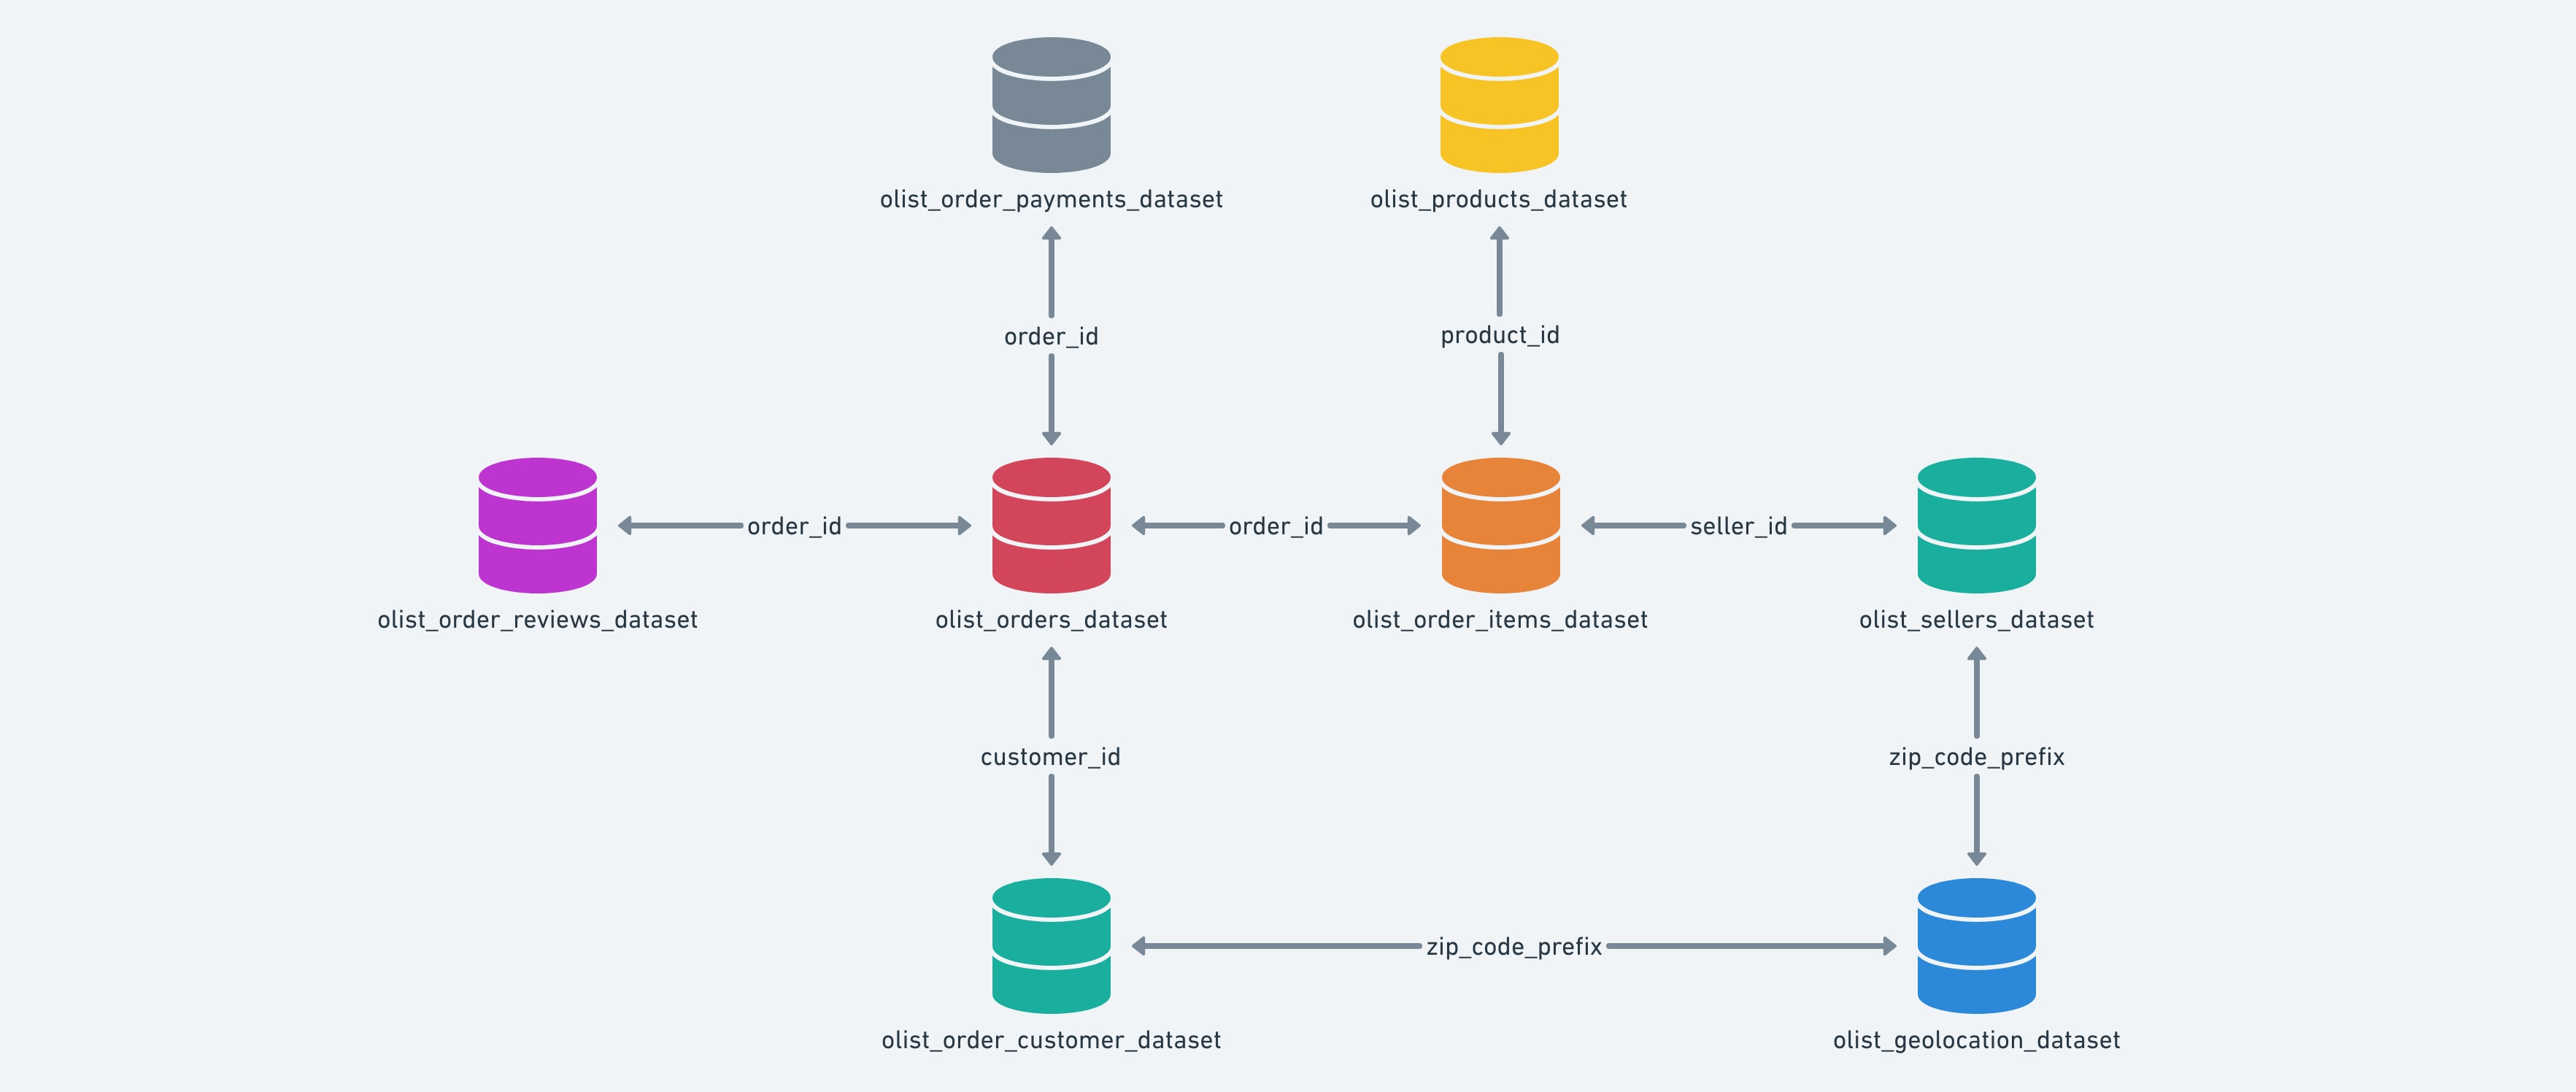

[Назад к содержанию](#table_of_contents)

## Шаг 1. Загрузка и изучение данных <a class='anchor' id='step_1'></a>

Загрузим необходимые библиотеки, функции и датасеты.

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import urllib
import datetime

pd.set_option('mode.chained_assignment', None)

In [7]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [8]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

In [9]:
customers = pd.read_csv('datasets/olist_customers_dataset.csv')

In [10]:
orders = pd.read_csv('datasets/olist_orders_dataset.csv')

In [11]:
order_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')

In [12]:
geolocations = pd.read_csv('datasets/olist_geolocation_dataset.csv')

Проверим каждый датасет на наличие дубликатов и пропусков, осмотрим общую информацию.

In [13]:
get_info(customers)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [14]:
get_na(customers)

,NaN
customer_id,0.00%
customer_unique_id,0.00%
customer_zip_code_prefix,0.00%
customer_city,0.00%
customer_state,0.00%


In [15]:
get_info(orders)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [16]:
get_na(orders)

,NaN
order_id,0.00%
customer_id,0.00%
order_status,0.00%
order_purchase_timestamp,0.00%
order_approved_at,0.16%
order_delivered_carrier_date,1.79%
order_delivered_customer_date,2.98%
order_estimated_delivery_date,0.00%


In [17]:
get_info(order_payments)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [18]:
get_na(order_payments)

,NaN
order_id,0.00%
payment_sequential,0.00%
payment_type,0.00%
payment_installments,0.00%
payment_value,0.00%


In [19]:
get_info(geolocations)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP



Число дубликатов: 261831

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


В датасете обнаружено около 26% дубликатов, устраним это позднее.

In [20]:
get_na(geolocations)

,NaN
geolocation_zip_code_prefix,0.00%
geolocation_lat,0.00%
geolocation_lng,0.00%
geolocation_city,0.00%
geolocation_state,0.00%


В остальных датасетах не обнаружено большого количества пропусков и дубликатов, данные готовы к предобработке.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

Создадим сводный датасет `data`, в котором запишем слияние датасета с заказами `orders` и датасета с данными о покупателях `customers`. Также, присоединим к таблице данные о сумме заказов `order_payments`.

In [21]:
data = orders.merge(customers, on='customer_id', how='left')

In [22]:
data = data.merge(order_payments, on='order_id', how='left')

In [23]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,credit_card,1.0,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3.0,voucher,1.0,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2.0,voucher,1.0,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,boleto,1.0,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1.0,credit_card,3.0,179.12


Рассмотрим в чем различается смысл данных в столбцах `customer_id` и `customer_unique_id`.

In [24]:
data[['order_id', 'customer_id', 'customer_unique_id']].head()

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8


In [25]:
print('Число покупателей:', data[['order_id', 'customer_id', 'customer_unique_id']]['customer_id'].nunique())
print('Число заказов:', data[['order_id', 'customer_id', 'customer_unique_id']]['order_id'].nunique())
print('Всего уникальных клиентов:', data[['order_id', 'customer_id', 'customer_unique_id']]['customer_unique_id'].nunique())

Число покупателей: 99441
Число заказов: 99441
Всего уникальных клиентов: 96096


Как мы видим, число покупателей и число уникальных клиентов различаются. 96 096 клиентов совершили в общей сложности 99 441 заказ.

Оставим в датасете `data` только необходимые столбцы:
- `order_id` - идентификатор заказа;
- `order_status` - статус заказа;
- `order_purchase_timestamp` - время оплаты заказа;
- `customer_unique_id` - уникальный идентификатор покупателя;
- `payment_value` - сумма заказа.

In [26]:
data = data[['order_id', 'order_status', 'order_purchase_timestamp', 'customer_unique_id', 'payment_value']]

In [27]:
data.head()

,order_id,order_status,order_purchase_timestamp,customer_unique_id,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12


Приведем столбец с временем оплаты заказа `order_purchase_timestamp` к временному формату.

In [28]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

Добавим отдельный столбец `purchase_date` c датой заказа и приведем его к временному формату.

In [29]:
data['purchase_date'] = data['order_purchase_timestamp'].dt.date
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [30]:
data.head()

,order_id,order_status,order_purchase_timestamp,customer_unique_id,payment_value,purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12,2017-10-02
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00,2017-10-02
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59,2017-10-02
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,2018-07-24
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018-08-08


Рассмотрим распределение статусов заказа в столбце `order_status`.

In [31]:
(data
 .groupby('order_status')
 .agg({'order_id':'nunique'})
 .reset_index()
 .sort_values(by='order_id', 
              ascending=False))

,order_status,order_id
3,delivered,96478
6,shipped,1107
1,canceled,625
7,unavailable,609
4,invoiced,314
5,processing,301
2,created,5
0,approved,2


В столбце `order_status` можно обнаружить следующие статусы:
- `delivered` - заказ доставлен;
- `shipped` - заказ отправлен
- `canceled` - заказ отменен;
- `unavailable` - заказ недоступен;
- `invoiced` - выставлен счет за заказ;
- `processing` - заказ в обработке;
- `created` - заказ создан;
- `approved` - заказ одобрен.


Для дальнейшего анализа оставим только сведения о доставленных заказах - статус `delivered`.

In [32]:
data = data[data['order_status'] == 'delivered']

Узнаем, какой временной период охватывают полученные данные.

In [33]:
print(data['order_purchase_timestamp'].min())
print(data['order_purchase_timestamp'].max())

2016-09-15 12:16:38
2018-08-29 15:00:37


Отфильтрованные данные охватывают отрезок размером около 2-х лет - с 15 сентября 2016 года по 29 августа 2018 года. Узнаем, сколько это в днях.

In [34]:
print(data['order_purchase_timestamp'].min() - data['order_purchase_timestamp'].max())

-714 days +21:16:01


Датасет включает в себя данные о 714 днях.

Создадим столбец `analysis_date`, в котором датой выполнения анализа зададим 29 августа 2018 года - `2018-08-29`. 

In [35]:
data['analysis_date'] = '2018-08-29'

Столбцы `purchase_date` и `analysis_date` приведем к временному формату и вычислим разницу между датой анализа и датой каждой покупки. Результат запишем в столбец `days`.

In [36]:
data[['purchase_date', 'analysis_date']] = data[['purchase_date', 'analysis_date']].apply(pd.to_datetime)
data['days'] = (data['analysis_date'] - data['purchase_date']).dt.days

In [37]:
data.head()

,order_id,order_status,order_purchase_timestamp,customer_unique_id,payment_value,purchase_date,analysis_date,days
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.12,2017-10-02,2018-08-29,331
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2.00,2017-10-02,2018-08-29,331
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,18.59,2017-10-02,2018-08-29,331
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,141.46,2018-07-24,2018-08-29,36
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,179.12,2018-08-08,2018-08-29,21


Теперь мы имеем все необходимые данные, чтобы собрать сводный датафрейм с профилями покупателей. Предварительно отсортировав датасет по дате покупки `purchase_date` по возрастанию, для каждого уникального клиента вычислим:
- `last_purchase_days_ago` - число дней с последней покупки;
- `total_orders` - суммарное количество заказов за исследуемый период;
- `total_value` - суммарные траты клиента на заказы. 

In [38]:
data = (data
        .sort_values(by='purchase_date')
        .groupby(['customer_unique_id'], as_index=False)
        .agg({'days': 'min', 'order_id':'count', 'payment_value': 'sum'})
        .rename(columns={'days':'last_purchase_days_ago',
                         'order_id':'total_orders',
                         'payment_value':'total_value'}))

Выведем полученный датафрейм `data`, отсортировав данные по количеству заказов.

In [39]:
data.sort_values(by='total_orders', ascending=False)

,customer_unique_id,last_purchase_days_ago,total_orders,total_value
56349,9a736b248f67d166d2fbb006bcb877c3,386,33,233.49
31650,569aa12b73b5f7edeaa6f2a01603e381,448,26,62.68
91110,f9ae226291893fda10af7965268fb7f6,536,23,521.07
13611,2524dcec233c3766f2c2b22f69fd65f4,264,22,40.85
40823,6fbc7cdadbb522125f4b27ae9dee4060,340,19,205.74
...,...,...,...,...
31983,577786ab410d98d13e0a00878cd9e8fa,106,1,234.39
31982,577782f64db1967ca343d0515ba9b1d7,172,1,62.47
31981,5777781eee24b7df08f8b6519917bfca,125,1,46.15
31980,57760bbba1b56ea6bbf29939e6c869ce,254,1,138.60


[Назад к содержанию](#table_of_contents)

## Шаг 3. Исследовательский анализ данных <a class='anchor' id='step_3'></a>

### Анализ профилей клиентов <a class='anchor' id='step_3_1'></a>

Рассмотрим основные признаки сводного датафрейма `data`.

count    93358.000000
mean       237.478877
std        152.595054
min          0.000000
25%        114.000000
50%        218.000000
75%        346.000000
max        713.000000
Name: last_purchase_days_ago, dtype: float64

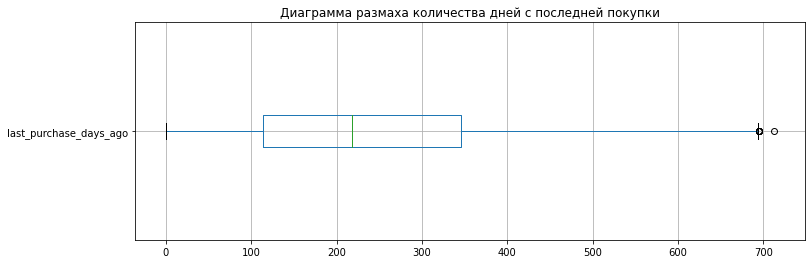

In [40]:
data.boxplot(column='last_purchase_days_ago', vert=False, figsize=(12, 4));
plt.title('Диаграмма размаха количества дней с последней покупки')
display(data['last_purchase_days_ago'].describe())

Медианное значение дней с последней покупки - 218 дней. В среднем клиенты совершают покупку раз в 237 дней.

Рассмотрим распределение значений количества заказов.

In [41]:
data['total_orders'].value_counts(normalize=True).head()

1    0.941473
2    0.049069
3    0.005613
4    0.001671
5    0.000750
Name: total_orders, dtype: float64

Распределение числа заказов выглядит так:
- 94% клиентов - совершили 1 заказ.
- 5% клиентов - совершили 2 заказа.
- 1% клиентов - совершили более 2 заказов.

Рассмотрим распределение трат клиентов на заказы.

count    93358.000000
mean       165.197003
std        226.314012
min          0.000000
25%         63.052500
50%        107.780000
75%        182.557500
max      13664.080000
Name: total_value, dtype: float64

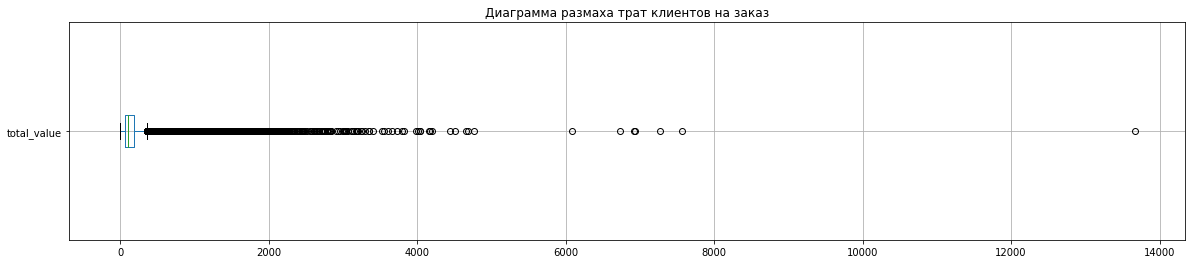

In [42]:
data.boxplot(column='total_value', vert=False, figsize=(20, 4))
plt.title('Диаграмма размаха трат клиентов на заказ')
display(data['total_value'].describe())

Медианное значение трат клиентов составляет 107 реалов. В среднем клиенты тратят 165 реалов на заказ.

[Назад к содержанию](#table_of_contents)

### Геоанализ клиентов <a class='anchor' id='step_3_2'></a>

Рассмотрим данные о геолокации покупателей и нанесем их на карту. 

In [43]:
unique_geolocations = geolocations.drop_duplicates(subset=['geolocation_zip_code_prefix'])

In [44]:
customers_geolocation = customers.merge(
    unique_geolocations,
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix',
    how='left'
)

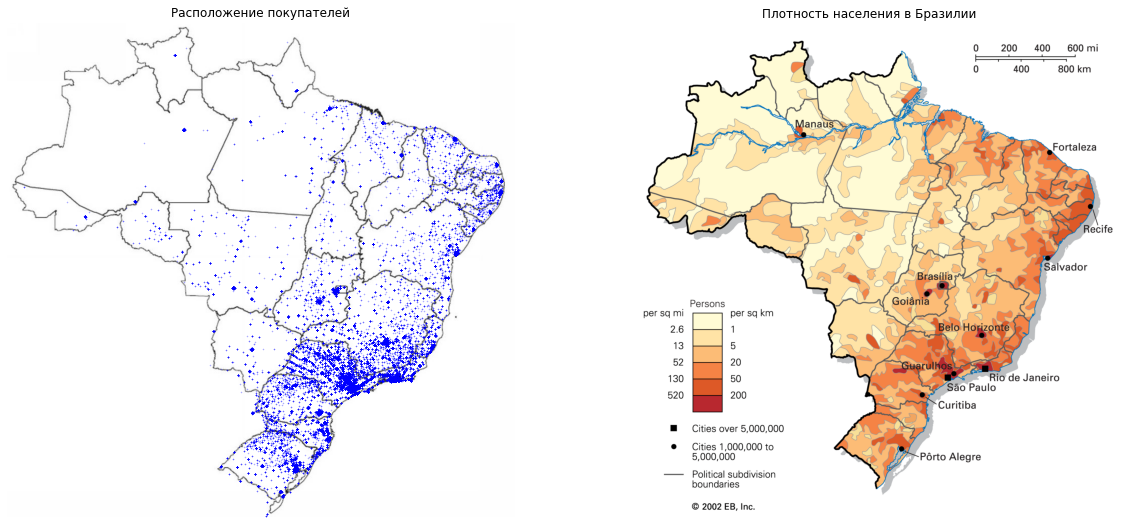

In [45]:
brazil = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/3a/0c/e1/3a0ce18b3c842748c255bc0aa445ad41.jpg'),'jpg')
brazil_pop = mpimg.imread(urllib.request.urlopen('https://i.pinimg.com/originals/49/6a/9e/496a9eb46b42ea18ec4cc9922ba1cec7.gif'),'gif')
fig, (ax1, ax2) = plt.subplots(1, 2)
customers_geolocation.plot(
    kind="scatter",
    x="geolocation_lng",
    y="geolocation_lat",
    ax = ax1,
    figsize=(20, 17),
    alpha=0.3,
    s=0.3,
    c='blue')

ax1.imshow(brazil, extent=[-73.98283055, -33.8,-33.75116944,5.4])
ax1.axis('off')
ax1.set_title('Расположение покупателей')
ax2.imshow(brazil_pop)
ax2.axis('off')
ax2.set_title('Плотность населения в Бразилии')
plt.show()

Наибольшее число заказов находится в областях с наибольшей плотностью населения - в южных штатах Бразилии и на восточном океанском побережье.

[Назад к содержанию](#table_of_contents)

### Анализ параметров доставки <a class='anchor' id='step_3_3'></a>

Рассмотрим распределение числа заказов в исследуемом периоде.

In [46]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'], format='%Y-%m-%d %H:%M:%S')

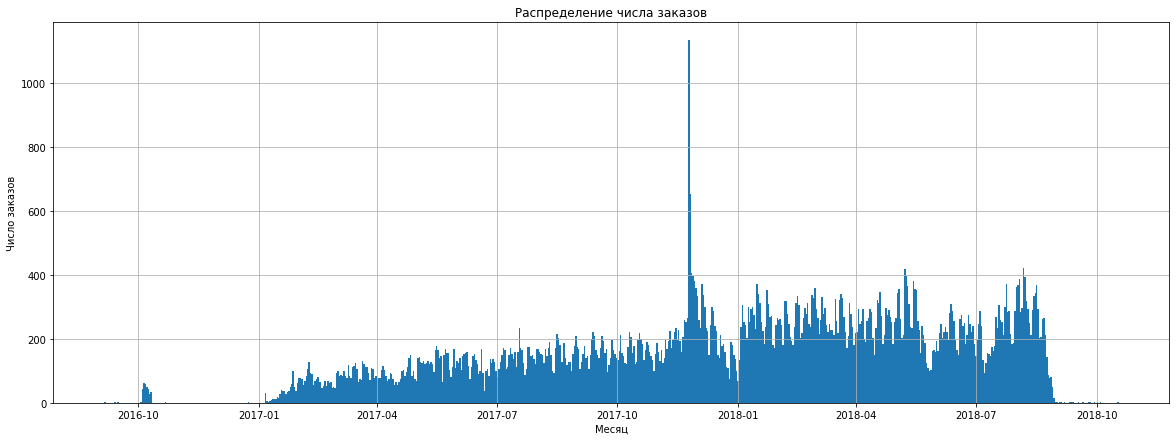

In [47]:
orders['order_purchase_timestamp'].hist(figsize = (20, 7), bins=700)
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.title('Распределение числа заказов');

На протяжении 2016 и 2017 годов число заказов в маркетплейсе не превышало 200 в день. Начиная с 2018 года произошел заметный рост числа заказов до 400 заказов в день. В ноябре 2017 года наблюдается рекордный пик числа заказов в день - более 1000. Рассмотрим его на предмет аномалии.

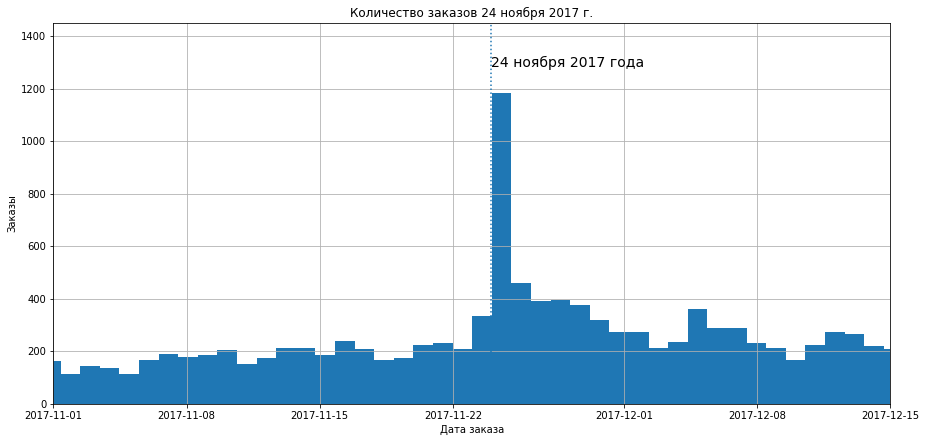

In [48]:
orders['order_purchase_timestamp'].hist(figsize=(15, 7), bins=750)
plt.xlim(left=datetime.datetime(2017, 11, 1, 0, 0), right=datetime.datetime(2017, 12, 15, 0, 0))
plt.ylim(top=1450)
plt.vlines(x=datetime.datetime(2017, 11, 24, 0, 0), ymin=0, ymax=1500, linestyle='dotted')
plt.text(datetime.datetime(2017, 11, 24, 0, 0), 1300, '24 ноября 2017 года', rotation=0, va='center', fontsize=14)
plt.title('Количество заказов 24 ноября 2017 г.')
plt.xlabel('Дата заказа')
plt.ylabel('Заказы');

По неопределенным причинам 24 ноября 2017 года наблюдался всплеск 1 176 заказов, которые были совершены уникальными клиентами. 

Рассмотрим распределение размера оплаты заказов.

In [49]:
order_payments['payment_value'].describe()

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

Медианное значение платежей составляет 100 реалов, в среднем клиенты совершают транзакции стоимостью 154 реала.

Рассмотрим распределение длительности доставки.

In [50]:
delivery_time = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
est_delivery_time = orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']
est_real_delivery_time = est_delivery_time - delivery_time

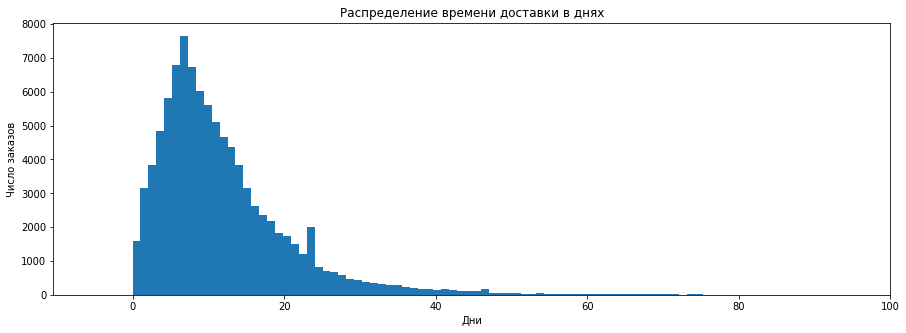

In [51]:
delivery_time.astype('timedelta64[D]').plot.hist(figsize=(15, 5), bins=200)
plt.xlim(right=100)
plt.xlabel('Дни')
plt.ylabel('Число заказов')
plt.title('Распределение времени доставки в днях');

Самое распространенное время доставки составляет около 6-8 дней.

Рассмотрим распределение примерного времени доставки в днях.

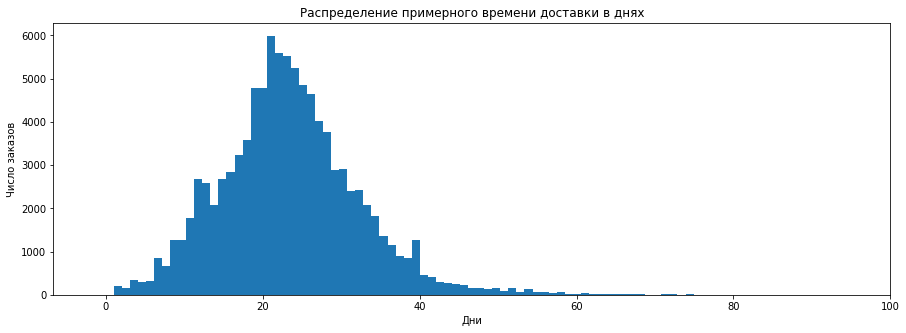

In [52]:
est_delivery_time.astype('timedelta64[D]').plot.hist(figsize = (15,5), bins = 150)
plt.xlim(right=100)
plt.xlabel('Дни')
plt.ylabel('Число заказов')
plt.title('Распределение примерного времени доставки в днях');

Предположительное время доставки чаще всего составляет около 20 дней.

Рассмотрим разницу между предположительным и фактическим временем доставки.

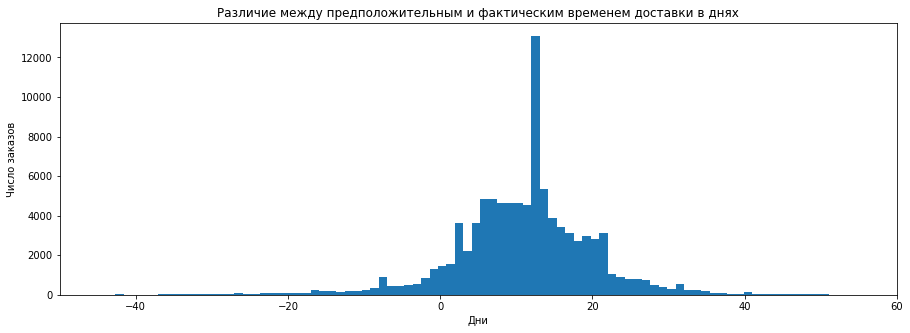

In [53]:
est_real_delivery_time.astype('timedelta64[D]').plot.hist(figsize=(15, 5), bins=300)
plt.xlim(right=60, left=-50)
plt.xlabel('Дни')
plt.ylabel('Число заказов')
plt.title('Различие между предположительным и фактическим временем доставки в днях');

Различие в предполагаемом и фактическом сроке доставки составляет в среднем 11 дней.

[Назад к содержанию](#table_of_contents)

## Шаг 4. RFM-анализ <a class='anchor' id='step_4'></a>

Создадим датафрейм `rfm_metrics`, в котором с помощью функции перцентиля рассчитаем основные параметры RFM-анализа:
- `Recency` — давность (как давно клиенты совершали покупку). Высокий показатель давности означает, что у клиента уже сложилось достаточно хорошее впечатление о бренде, поэтому он недавно его услуги. Давность в срезе клиентской базы можно посмотреть, если отсортировать клиентов по дате последней покупки.
- `Frequency` — частота (как часто клиенты совершают покупают). Высокий показатель частоты говорит о том, что клиенту нравится бренд, товары и услуги, поэтому он часто возвращается. Для расчета частоты посещения нужно общее количество покупок/визитов разделить на количество месяцев/дней/лет и т.д.
- `Monetary` — деньги (общая сумма трат). Высокий уровень этого показателя означает, что клиенту нравится тратить именно на этом маркетплейсе.

In [54]:
names = ['Давность 1/3 клиентов, дней',
         'Давность 2/3 клиентов, дней',
         'Покупок 1/3 клиентов, кол-во',
         'Покупок 2/3 клиентов, кол-во',
         'Сумма 1/3 клиентов, $', 
         'Сумма 2/3 клиентов, $']

metrics = [data['last_purchase_days_ago'].quantile(q=0.33),
           data['last_purchase_days_ago'].quantile(q=0.67),
           data['total_orders'].quantile(q=0.33),
           data['total_orders'].quantile(q=0.67),
           data['total_value'].quantile(q=0.33),
           data['total_value'].quantile(q=0.67)]

rfm_metrics = pd.DataFrame()
rfm_metrics['Показатели RFM'] = names
rfm_metrics['Значение'] = metrics
rfm_metrics.index = ['R_1/3', 'R_2/3', 'F_1/3', 'F_2/3', 'M_1/3', 'M_2/3']
rfm_metrics

,Показатели RFM,Значение
R_1/3,"Давность 1/3 клиентов, дней",147.00
R_2/3,"Давность 2/3 клиентов, дней",291.00
F_1/3,"Покупок 1/3 клиентов, кол-во",1.00
F_2/3,"Покупок 2/3 клиентов, кол-во",1.00
M_1/3,"Сумма 1/3 клиентов, $",74.63
M_2/3,"Сумма 2/3 клиентов, $",153.01


Параметры давности:
- 33% клиентов совершили покупку в период последних 147 дней.
- 67% клиентов совершили покупку в период последних 291 дня.

Параметры частоты:
- 67% клиентов совершили не более 1 заказа.

Параметры трат:
- 33% клиентов тратили на заказ не более 74.63 реала;  
- 67% клиентов тратили на заказ не более 153.01 реала.  

Распределим каждого клиента по трем категориям для каждого RFM-признака в зависимости от значения.

In [55]:
conditions_R = [
    (data['last_purchase_days_ago'] <= data['last_purchase_days_ago'].quantile(q=0.33)),
    (data['last_purchase_days_ago'] <= data['last_purchase_days_ago'].quantile(q=0.67)),
    (data['last_purchase_days_ago'] > data['last_purchase_days_ago'].quantile(q=0.67))
]

conditions_F = [
    (data['total_orders'] < data['total_orders'].quantile(q=0.33)),
    (data['total_orders'] < data['total_orders'].quantile(q=0.67)),
    (data['total_orders'] >= data['total_orders'].quantile(q=0.67))
]

conditions_M = [
    (data['total_value'] <= data['total_value'].quantile(q=0.33)),
    (data['total_value'] <= data['total_value'].quantile(q=0.67)),
    (data['total_value'] > data['total_value'].quantile(q=0.67))
]

values_R = [1, 2, 3]
values_F = [3, 2, 1]
values_M = [3, 2, 1]

data['recency'] = np.select(conditions_R, values_R)
data['frequency'] = np.select(conditions_F, values_F)
data['monetary'] = np.select(conditions_M, values_M)

Добавим столбец `rfm_score`, в котором произведем конкатенацию RFM-признаков в единое score-значение.

In [56]:
data['rfm_score'] = data['recency'].map(str) + data['frequency'].map(str) + data['monetary'].map(str)

In [57]:
data.head()

,customer_unique_id,last_purchase_days_ago,total_orders,total_value,recency,frequency,monetary,rfm_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,1,1,2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,1,1,3,113
2,0000f46a3911fa3c0805444483337064,537,1,86.22,3,1,2,312
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,3,1,3,313
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,2,1,1,211


Поскольку методы сегментации по принципам RFM-анализа основаны на перцентилях, мы получаем относительно равные между собой сегменты.

In [58]:
data['rfm_score'].value_counts()

312    10636
213    10633
112    10593
211    10510
212    10504
111    10442
313    10270
113     9916
311     9854
Name: rfm_score, dtype: int64

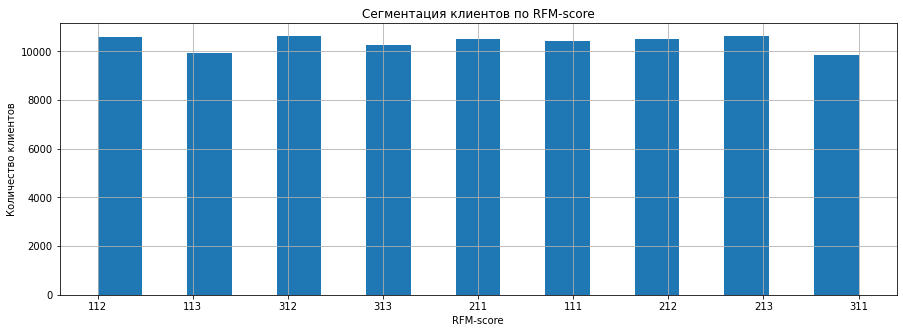

In [59]:
data['rfm_score'].hist(figsize=(15, 5), bins=17)
plt.title('Сегментация клиентов по RFM-score')
plt.xlabel('RFM-score')
plt.ylabel('Количество клиентов');

На полученные сегменты клиентов можно влиять в зависимости от цели компании. Наиболее ценные клиенты категории 111 - часто покупают и много. Смежная (не целевая) группа в нашем анализе относится к категории 313 - купили лишь однажды и на малую сумму.

[Назад к содержанию](#table_of_contents)

## Выводы <a class='anchor' id='final'></a>

В процессе исследовательского анализа данных были получены следующие выводы:
1. Медианное значение дней с последней покупки - 218 дней. В среднем клиенты совершают покупку раз в 237 дней.
2. 94% клиентов - совершили 1 заказ, 5% клиентов - совершили 2 заказа, 1% клиентов - совершили более 2 заказов.
3. Медианное значение совокупных трат клиентов составляет 107 реалов. В среднем клиенты тратят 165 реалов на заказ.
4. Наибольшее число заказов находится в областях с наибольшей плотностью населения - в южных штатах Бразилии и на восточном океанском побережье.
5. На протяжении 2016 и 2017 годов число заказов в маркетплейсе не превышало 200 в день. Начиная с 2018 года произошел заметный рост числа заказов до 400 заказов в день. В ноябре 2017 года наблюдается рекордный пик числа заказов в день - более 1000.
6. По неопределенным причинам 24 ноября 2017 года наблюдался всплеск 1 176 заказов, которые были совершены уникальными клиентами.
7. Медианное значение платежей составляет 100 реалов, в среднем клиенты совершают транзакции стоимостью 154 реала.
8. Самое распространенное время доставки составляет около 6-8 дней.
9. Предположительное время доставки чаще всего составляет около 20 дней.
10. Различие в предполагаемом и фактическом сроке доставки составляет в среднем 11 дней.
11. 33% клиентов совершили покупку в период последних 147 дней, 67% клиентов совершили покупку в период последних 291 дня.
12. 33% клиентов тратили на заказ не более 74.63 реала, 67% клиентов тратили на заказ не более 153.01 реала.

[Назад к содержанию](#table_of_contents)